## Question 1: Training a Light Score-Based Generative Model with Sliced Score Matching on MNIST

**Objective:** Implement and train a lightweight score-based generative model using the sliced score matching technique. The goal is to learn the data distribution's score for generating new samples similar to the training data.

**Dataset:** Use the MNIST dataset, which consists of 70,000 28x28 grayscale images of handwritten digits (0-9). It is divided into 60,000 training images and 10,000 test images. MNIST can be found at https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html To reduce computational complexity, you can downscale the MNIST images to 7x7. Both score models trained with 28x28 and with 7x7 MNIST will get full credits.

**Tasks:**
1. Data preparation: Normalize the MNIST images to have pixel values between -1 and 1.
2. Model Architecture: Construct a simple convolutional neural network (CNN) for estimating the data distribution's score. This network should accept a noisy image as input and output a score estimate.
3. Sliced Score Matching: Implement the sliced score matching objective. Add Gaussian noise to the input images, and train the model to approximate the score of the noise-perturbed data distribution.
4. Training: Use a smaller batch size if necessary to accommodate memory constraints. Train the model using a straightforward optimizer like Adam, with a conservative learning rate (e.g., 1e-3). Consider reducing the number of training epochs and implementing checkpointing to save the model intermittently.
5. Evaluation and Generation: Evaluate the model qualitatively by visual inspection of generated digits.

(A helpful website: https://github.com/mfkasim1/score-based-tutorial/blob/main/01-SGM-without-SDE.ipynb)

In [30]:
# Import pacakges

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
import itertools
import matplotlib.pyplot as plt
from functools import partial

In [31]:
# Set the random seeds
torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cuda:4


In [32]:
EMBEDDING_DIM = 20 # The dimension of the embeddings

class AutoEncoder(nn.Module):
    """
    A simple autoencoder for images. 
    self.linear1 generates the intermediate embeddings that we use for the normalizing flow.
    """
    def __init__(self):
        super().__init__()
        
        # Encoding layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, stride=2, kernel_size=3, bias=False, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, stride=2, kernel_size=3, bias=False, padding=1)
        self.linear1 = nn.Linear(in_features=3136, out_features=EMBEDDING_DIM)
        
        # Decoding layers
        self.linear2 = nn.Linear(in_features=EMBEDDING_DIM, out_features=3136)
        self.convt1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=3, padding=1, output_padding=1)
        self.convt2 = nn.ConvTranspose2d(in_channels=32, out_channels=1, stride=2, kernel_size=3, padding=1, output_padding=1)


    def forward(self, x):
        
        emb = self.encoder(x)
        _x = self.decoder(emb)
        
        return _x, emb
    
    def decoder(self, emb):

        _x = torch.relu(self.linear2(emb))
        _x = _x.view(-1, 64, 7, 7)
        _x = torch.relu(self.convt1(_x))
        _x = self.convt2(_x)
        
        return _x
    
    def encoder(self, x):
        _x = torch.relu(self.conv1(x))
        _x = torch.relu(self.conv2(_x))
        sh = _x.shape

        _x = torch.relu(torch.flatten(_x, 1))
        
        emb = self.linear1(_x)
        
        return emb

In [33]:
BATCH_SIZE = 100 # Batch size
# Load the dataset
train_set = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))
train_loader = torch.utils.data.DataLoader(train_set, BATCH_SIZE)

test_set = datasets.MNIST('./data', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

In [34]:
AE_EPOCHS = 10 # Epochs for training the autoencoder
# We use a binary cross-entropy loss for the reconstruction error
loss_f = nn.BCELoss()

# Build the autoencoder
autoencoder = AutoEncoder()
autoencoder = autoencoder.to(device)

optimizer = torch.optim.Adam(itertools.chain(autoencoder.parameters()),
                             lr=1e-3, weight_decay=1e-5)

for i in range(AE_EPOCHS):
    print('Epoch #{}'.format(i+1))

    losses = []
    for batch_idx, data in enumerate(train_loader):

        x, _ = data
        x = x.to(device)

        # Run the autoencoder
        _x, emb = autoencoder(x)
        _x = torch.sigmoid(_x)

        # Compute loss
        rec_loss = loss_f(_x, x)

        if batch_idx % 200 == 0:
            print(f"E {i}, {batch_idx:.3f}/{len(train_loader)}: Loss: {rec_loss.item()}")

        autoencoder.zero_grad()
        rec_loss.backward()
        optimizer.step()

Epoch #1
E 0, 0.000/600: Loss: 0.6272263526916504
E 0, 200.000/600: Loss: 0.15188480913639069
E 0, 400.000/600: Loss: 0.1100916787981987
Epoch #2
E 1, 0.000/600: Loss: 0.10403434932231903
E 1, 200.000/600: Loss: 0.10046017169952393
E 1, 400.000/600: Loss: 0.09293199330568314
Epoch #3
E 2, 0.000/600: Loss: 0.09380815923213959
E 2, 200.000/600: Loss: 0.0928587093949318
E 2, 400.000/600: Loss: 0.08815015107393265
Epoch #4
E 3, 0.000/600: Loss: 0.08926934748888016
E 3, 200.000/600: Loss: 0.08879468590021133
E 3, 400.000/600: Loss: 0.08568316698074341
Epoch #5
E 4, 0.000/600: Loss: 0.0869121104478836
E 4, 200.000/600: Loss: 0.08662018179893494
E 4, 400.000/600: Loss: 0.08432313054800034
Epoch #6
E 5, 0.000/600: Loss: 0.08575589954853058
E 5, 200.000/600: Loss: 0.08528918772935867
E 5, 400.000/600: Loss: 0.08336909860372543
Epoch #7
E 6, 0.000/600: Loss: 0.08453305810689926
E 6, 200.000/600: Loss: 0.08421993255615234
E 6, 400.000/600: Loss: 0.08274777233600616
Epoch #8
E 7, 0.000/600: Loss: 

In [36]:
torch.save(autoencoder.state_dict(), "autoencoder.pth")
# autoencoder.load_state_dict(torch.load("autoencoder.pth", map_location='cpu'))

torch.Size([1, 1, 28, 28])


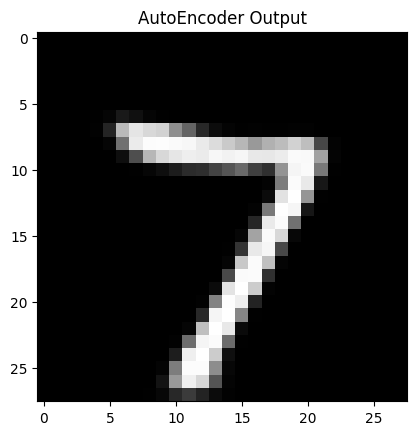

In [37]:
test_image = test_set[0][0].unsqueeze(0)
test_image = test_image.to(device)
_o, emb = autoencoder(test_image)
_o = torch.sigmoid(_o)
print(_o.shape)

## Display the image
plt.imshow(_o.squeeze().detach().cpu(), cmap='gray');
plt.title("AutoEncoder Output");

In [38]:
## 1. Extract all the data to embeddings
import tqdm

embs = []
with torch.no_grad():
    for data in tqdm.tqdm(train_loader):
        x, _ = data
        x = x.to(device)

        emb = autoencoder.encoder(x).cpu()
        for e in emb:
            embs.append(e)

print(len(embs))

100%|██████████| 600/600 [00:10<00:00, 56.07it/s]

60000


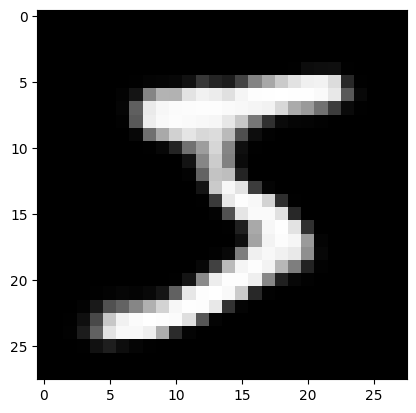

In [39]:
out = torch.sigmoid(autoencoder.decoder(embs[0].to(device)))
out.shape
plt.imshow(out[0][0].cpu().detach().numpy(), cmap='gray')

In [40]:
BATCH_SIZE=30
emb_dataset = torch.utils.data.DataLoader(embs, batch_size=BATCH_SIZE, shuffle = True)

In [41]:
## Energy Models

class MLP(nn.Module):
    def __init__(self, input_dim=20, hidden_dims=[256, 128], output_dim=20): # the output dimension has to be 1d
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        x = self.fc3(x)  # logits for classification
        return x

In [42]:
x = torch.randn(1, 20)
model = MLP()
model(x).shape

torch.Size([1, 20])

In [49]:
from functorch import jacrev, vmap

def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    score = score_network(x)  # score: (b, 1, w, h)
    # score = score.reshape(score.size(0), -1)
    
    # first term: half of the squared norm
    term1 = torch.linalg.norm(score, dim=-1) ** 2 * 0.5
    
    # second term: trace of the Jacobian
    jac = vmap(jacrev(score_network))(x)  # (batch_size, 2, 2)
    term2 = torch.einsum("bii->b", jac)  # compute the trace
    return (term1 + term2).mean()

In [50]:
score_network = MLP()
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
resume=""

if resume != "":
    print(f"loading model from {resume}")
    ckpt = torch.load(resume, map_location='cpu')
    score_network.load_state_dict(ckpt['model_state_dict'])
    opt.load_state_dict(ckpt['optim_state_dict'])
score_network.to(device);

In [51]:
"""Training"""
import time
import datetime
EPOCH=10
LOG_INTERVAL=100

BATCH_SIZE=100
emb_dataset = torch.utils.data.DataLoader(embs, batch_size=BATCH_SIZE, shuffle = True)

train_loader = emb_dataset

start = time.time()
for i_epoch in range(EPOCH):
    total_loss = 0
    for i, data in enumerate(train_loader):
        opt.zero_grad()
        data= data.to(device)

        # training step
        score_network.zero_grad()
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item()
        
        if i % LOG_INTERVAL == 0:
            print(f"[Epoch {i_epoch}] | [{i}|{len(train_loader)}] loss: {loss.item()}, avg loss: {total_loss/(i+1)} est epoch: {datetime.timedelta(seconds=(len(train_loader) -1 - i) / LOG_INTERVAL * (time.time() - start))}")
            start = time.time()
    # torch.save({"model_state_dict": score_network.state_dict(), "optim_state_dict": opt.state_dict()}, f"epoch_{i_epoch}.pth")

[Epoch 0] | [0|2000] loss: 2.6170341968536377, avg loss: 2.6170341968536377 est epoch: 0:00:08.855881
[Epoch 0] | [100|2000] loss: -0.8797305226325989, avg loss: -0.26410853943907386 est epoch: 0:00:23.007393
[Epoch 0] | [200|2000] loss: -1.270411729812622, avg loss: -0.7336140617135152 est epoch: 0:00:22.247891
[Epoch 0] | [300|2000] loss: -2.2623534202575684, avg loss: -1.0429631476336936 est epoch: 0:00:20.130666
[Epoch 0] | [400|2000] loss: -1.5142074823379517, avg loss: -1.2738914100866663 est epoch: 0:00:18.965148
[Epoch 0] | [500|2000] loss: -2.1062328815460205, avg loss: -1.4700565957231913 est epoch: 0:00:17.349310
[Epoch 0] | [600|2000] loss: -2.750885486602783, avg loss: -1.6356012833470512 est epoch: 0:00:16.301075
[Epoch 0] | [700|2000] loss: -2.1612679958343506, avg loss: -1.7838609096475913 est epoch: 0:00:14.554088
[Epoch 0] | [800|2000] loss: -3.2518985271453857, avg loss: -1.9257254971379645 est epoch: 0:00:13.027706
[Epoch 0] | [900|2000] loss: -2.6844658851623535, a

KeyboardInterrupt: 

In [53]:
score_network
torch.save(score_network.state_dict(), "score_model.pth")

In [98]:
import numpy as np 
import tqdm

@torch.no_grad()
def mala_sample(x, model, n_steps, n_sample_out, step = 0.2, verbose = False):

    def log_q_y_x(model, step, y, x):
        grad = model(x)
        norm = -torch.norm((y - x.detach() - step / 2 * grad), 2)**2 / (4 * step)
        return norm

    def log_accept_prob(model, z_new, z, step):
        left = 1
        right = log_q_y_x(model, step, z, z_new) - log_q_y_x(model,step, z_new, z)
        prob = left + right
        # print(left.shape)
        return min(0, prob)
    
    res = []
    
    z  = torch.clone(x)
   
    pbar = range(n_steps)
    if verbose:
        pbar = tqdm.tqdm(pbar)

    for _ in pbar:
        grad = model(z)
        z_new = z.detach() + step / 2 * grad + torch.randn(z.size(0), device=z.device) * np.sqrt(step)
        # a_log_prob = log_accept_prob(model, z_new, z, step)
        # if torch.log(torch.rand(1)).item() < a_log_prob:
        z = z_new
        res.append(z.detach())
        # if verbose:
        #     pbar.set_description(f"z value {z}, a log prob: {a_log_prob}")
    return torch.stack(res, axis = 0)[-n_sample_out:]

In [164]:
out = mala_sample(torch.randn(1,20).to(device), score_network, 1000, 1, step=0.1, verbose=True)
print(out.shape)

100%|██████████| 1000/1000 [00:00<00:00, 2595.47it/s]

torch.Size([1, 1, 20])


In [165]:
out = autoencoder.decoder(out.squeeze(0))
out = torch.sigmoid(out)

torch.Size([1, 1, 28, 28])


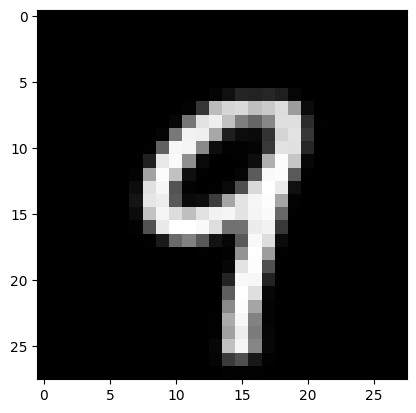

In [166]:
print(out.shape)
plt.imshow(out.squeeze().detach().cpu().numpy(), cmap='gray')

In [67]:
def generate_samples(score_net: torch.nn.Module, nsamples: int, eps: float = 0.001, nsteps: int = 1000) -> torch.Tensor:
    # generate samples using Langevin MCMC
    # x0: (sample_size, nch)
    x0 = torch.rand((nsamples, 20)).to(device) * 2 - 1
    for i in range(nsteps):
        z = torch.randn_like(x0)
        x0 = x0 + eps * score_net(x0) + (2 * eps) ** 0.5 * z
    return x0

In [85]:
out = generate_samples(score_network, nsamples=10, nsteps=50000)

In [86]:
out = autoencoder.decoder(out.squeeze(0))
out = torch.sigmoid(out)
print(out.shape)

torch.Size([10, 1, 28, 28])


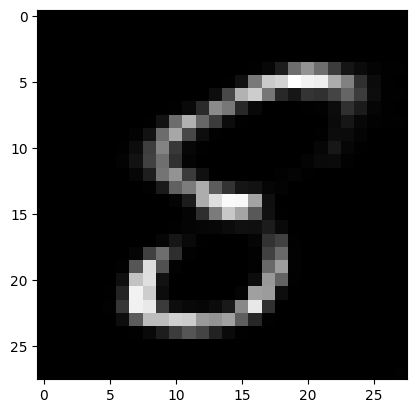

In [92]:
plt.imshow(out.squeeze()[5].detach().cpu().numpy(), cmap='gray')